In [2]:
import os

# Zip dosyasını çıkartma
zip_path = "/content/drive/MyDrive/Ara Proje/datalar/UCLM_and_DatasetB.zip"
!unzip -o -q "{zip_path}" -d /content/domain_data

print("✅ Domain verileri hazırlandı.")

✅ Domain verileri hazırlandı.


In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os

# --- 1. MODELİ YÜKLE (En son eğittiğimiz şampiyon model) ---
model_path = "/content/drive/MyDrive/Ara Proje/saved_models/ResNet_Results/Resnet_model_with_BUSI(-5).keras"
model = load_model(model_path)

# --- 2. VERİ YÜKLEYİCİLER ---
BASE_PATH = "/content/domain_data/content/final_dataset"
train_path = os.path.join(BASE_PATH, "train")
val_path = os.path.join(BASE_PATH, "val")

target_datagen = ImageDataGenerator(rescale=1./255)

target_train_gen = target_datagen.flow_from_directory(
    train_path, target_size=(224, 224), batch_size=16, class_mode='categorical'
)
target_val_gen = target_datagen.flow_from_directory(
    val_path, target_size=(224, 224), batch_size=16, class_mode='categorical', shuffle=False
)

# --- 3. MODELİ GÜNCELLE (Fine-Tuning Ayarları) ---
# ResNet'in son 50 katmanını açık tutuyoruz (BUSI eğitimindeki gibi devam ediyoruz)
model.trainable = True
for layer in model.layers[:-50]:
    layer.trainable = False

# Çok düşük bir learning rate ile yeni alanın dokularını öğretiyoruz
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Ezberlemeyi durduran mekanizma
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)

# --- 4. ADAPTASYON EĞİTİMİ ---
print("\n🚀 ResNet50 Domain Adaptation Başlıyor...")
model.fit(
    target_train_gen,
    validation_data=target_val_gen,
    epochs=20,
    callbacks=[early_stopping]
)

# --- 5. FİNAL MODEL KAYDI ---
save_dir = "/content/drive/MyDrive/Ara Proje/saved_models/ResNet_Results"
os.makedirs(save_dir, exist_ok=True)
final_save_path = os.path.join(save_dir, "RESNET_DomainAD_Final.keras")
model.save(final_save_path)

print(f"\n✅ ResNet Domain Adaptation Tamamlandı: {final_save_path}")

Found 2826 images belonging to 3 classes.
Found 127 images belonging to 3 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 64 variables whereas the saved optimizer has 126 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



🚀 ResNet50 Domain Adaptation Başlıyor...
Epoch 1/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 66s 223ms/step - accuracy: 0.5099 - loss: 1.1143 - val_accuracy: 0.5433 - val_loss: 1.1896
Epoch 2/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 18s 101ms/step - accuracy: 0.6625 - loss: 0.7946 - val_accuracy: 0.7165 - val_loss: 0.7443
Epoch 3/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 18s 100ms/step - accuracy: 0.7050 - loss: 0.6998 - val_accuracy: 0.6535 - val_loss: 0.8161
Epoch 4/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 18s 101ms/step - accuracy: 0.7326 - loss: 0.6537 - val_accuracy: 0.7244 - val_loss: 0.6981
Epoch 5/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 18s 99ms/step - accuracy: 0.7450 - loss: 0.6041 - val_accuracy: 0.7244 - val_loss: 0.7581
Epoch 6/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 18s 100ms/step - accuracy: 0.7936 - loss: 0.5092 - val_accuracy: 0.7087 - val_loss: 0.7412
Epoch 7/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 18s 100ms/step - accuracy: 0.8105 - loss: 0.4730 - val_accuracy: 0.6457 - val_loss: 0.9785
Epoch 8/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 17


🔎 ResNet50 Domain Adaptation Test Sonuçları Hesaplanıyor...
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 782ms/step

📊 RESNET50 DOMAIN ADAPTATION: TOTAL SONUÇLAR
Toplam Doğruluk (Accuracy)  : 0.7244
Genel Kesinlik (Precision) : 0.7238
Genel Duyarlılık (Recall)  : 0.7244
Genel F1-Skoru (F1-Score)  : 0.7146

📋 Detaylı Sınıf Raporu:
              precision    recall  f1-score   support

      benign       0.72      0.50      0.59        42
   malignant       0.56      0.64      0.60        22
      normal       0.78      0.90      0.84        63

    accuracy                           0.72       127
   macro avg       0.69      0.68      0.68       127
weighted avg       0.72      0.72      0.71       127



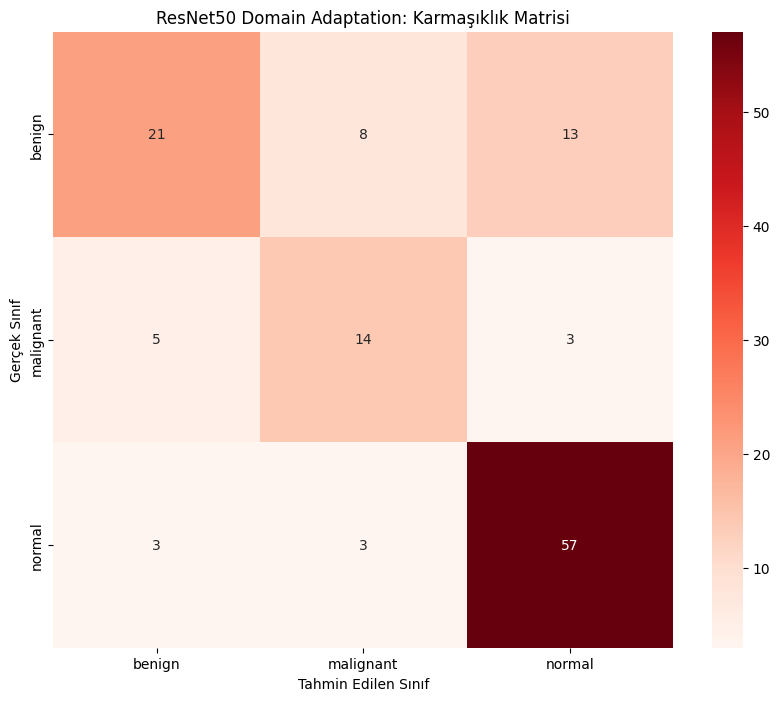

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model

# 1. MODELİ YÜKLE (En iyi ağırlıklar geri yüklenmiş hali)
# Eğer modeli kaydettiysen o yolu kullanabilirsin, yoksa mevcut 'model' değişkeni üzerinden devam eder.
# model = load_model("/content/drive/MyDrive/Ara Proje/saved_models/ResNet_Results2/RESNET_DomainAD_Final.keras")

# 2. TAHMİNLERİ AL (target_val_gen üzerinden)
print("\n🔎 ResNet50 Domain Adaptation Test Sonuçları Hesaplanıyor...")
Y_pred = model.predict(target_val_gen)
y_pred = np.argmax(Y_pred, axis=1)
y_true = target_val_gen.classes
labels = list(target_val_gen.class_indices.keys())

# 3. TOTAL METRİKLERİ HESAPLA
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("\n" + "="*50)
print("📊 RESNET50 DOMAIN ADAPTATION: TOTAL SONUÇLAR")
print("="*50)
print(f"Toplam Doğruluk (Accuracy)  : {accuracy:.4f}")
print(f"Genel Kesinlik (Precision) : {precision:.4f}")
print(f"Genel Duyarlılık (Recall)  : {recall:.4f}")
print(f"Genel F1-Skoru (F1-Score)  : {f1:.4f}")
print("="*50)

# 4. DETAYLI SINIF RAPORU
print("\n📋 Detaylı Sınıf Raporu:")
print(classification_report(y_true, y_pred, target_names=labels))

# 5. KARMAŞIKLIK MATRİSİ GÖRSELLEŞTİRME
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=labels, yticklabels=labels)
plt.title('ResNet50 Domain Adaptation: Karmaşıklık Matrisi')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.show()

In [7]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# 1. DOSYALARI HAZIRLA
zip_path = 'deneme.zip'
extract_path = '/content/deneme_klasoru'

if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("✅ deneme.zip başarıyla açıldı.")
else:
    print("❌ Hata: deneme.zip dosyası bulunamadı. Lütfen sol taraftaki dosya menüsüne yüklediğinden emin ol.")

# 2. MODELİ YÜKLE (Domain Adaptation yapılmış final model)
model_path = "/content/drive/MyDrive/Ara Proje/saved_models/ResNet_Results/RESNET_DomainAD_Final.keras"
model = load_model(model_path)
labels = ['benign', 'malignant', 'normal']

# 3. TAHMİNLEME FONKSİYONU
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Eğitimde kullandığımız normalizasyon

    prediction = model.predict(img_array, verbose=0)
    result = labels[np.argmax(prediction)]
    confidence = np.max(prediction) * 100
    return result, confidence

# 4. KLASÖRDEKİ TÜM RESİMLERİ TAHMİN ET
print("\n--- 🔎 TAHMİN SONUÇLARI ---")
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')

for root, dirs, files in os.walk(extract_path):
    for file in files:
        if file.lower().endswith(valid_extensions):
            full_path = os.path.join(root, file)
            res, conf = predict_image(full_path)
            print(f"📄 Dosya: {file}  ==>  🎯 Tahmin: {res.upper()} (%{conf:.2f} güven)")

print("\n✅ Tüm tahminlemeler tamamlandı.")

✅ deneme.zip başarıyla açıldı.

--- 🔎 TAHMİN SONUÇLARI ---
📄 Dosya: benign (107)-rotated2-sharpened.png  ==>  🎯 Tahmin: BENIGN (%88.80 güven)
📄 Dosya: benign (105)-rotated2.png  ==>  🎯 Tahmin: BENIGN (%50.70 güven)
📄 Dosya: benign (102)-rotated2-rotated1.png  ==>  🎯 Tahmin: NORMAL (%55.48 güven)
📄 Dosya: malignant (109)-rotated1-rotated32.png  ==>  🎯 Tahmin: MALIGNANT (%65.77 güven)
📄 Dosya: malignant (110)-rotated32-rotated2.png  ==>  🎯 Tahmin: NORMAL (%48.04 güven)
📄 Dosya: malignant (105)-rotated32.png  ==>  🎯 Tahmin: MALIGNANT (%53.67 güven)
📄 Dosya: benign (108)-rotated2-rotated2.png  ==>  🎯 Tahmin: NORMAL (%80.12 güven)
📄 Dosya: benign (110)-sharpened-sharpened.png  ==>  🎯 Tahmin: MALIGNANT (%86.45 güven)
📄 Dosya: benign (105)-rotated2-rotated2.png  ==>  🎯 Tahmin: BENIGN (%74.17 güven)
📄 Dosya: benign (111)-rotated1-sharpened.png  ==>  🎯 Tahmin: MALIGNANT (%56.99 güven)
📄 Dosya: malignant (108)-rotated1-rotated32.png  ==>  🎯 Tahmin: MALIGNANT (%42.56 güven)
📄 Dosya: benign (103)-